### Custom CNN

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images


2025-01-31 03:28:20,722 - Epoch 1/20: Train Loss = 0.3096, Train Acc = 0.8923, Val Loss = 0.1879, Val Acc = 0.9628
2025-01-31 03:28:21,481 - Epoch 2/20: Train Loss = 0.1459, Train Acc = 0.9744, Val Loss = 0.1222, Val Acc = 0.9826
2025-01-31 03:28:22,231 - Epoch 3/20: Train Loss = 0.1013, Train Acc = 0.9826, Val Loss = 0.0850, Val Acc = 0.9850
2025-01-31 03:28:22,976 - Epoch 4/20: Train Loss = 0.0720, Train Acc = 0.9882, Val Loss = 0.0692, Val Acc = 0.9886
2025-01-31 03:28:23,723 - Epoch 5/20: Train Loss = 0.0529, Train Acc = 0.9908, Val Loss = 0.0562, Val Acc = 0.9880
2025-01-31 03:28:24,468 - Epoch 6/20: Train Loss = 0.0464, Train Acc = 0.9914, Val Loss = 0.0556, Val Acc = 0.9868
2025-01-31 03:28:25,215 - Epoch 7/20: Train Loss = 0.0369, Train Acc = 0.9922, Val Loss = 0.0519, Val Acc = 0.9880
2025-01-31 03:28:25,962 - Epoch 8/20: Train Loss = 0.0291, Train Acc = 0.9954, Val Loss = 0.0431, Val Acc = 0.9892
2025-01-31 03:28:26,710 - Epoch 9/20: Train Loss = 0.0241, Train Acc = 0.9956, V

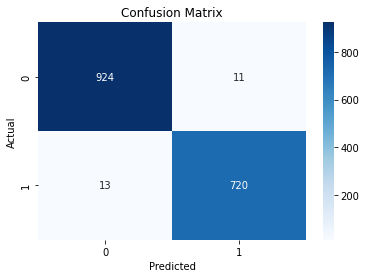

2025-01-31 03:28:35,013 - Macro-Averaged F1 Score: 0.9854


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       935
           1       0.98      0.98      0.98       733

    accuracy                           0.99      1668
   macro avg       0.99      0.99      0.99      1668
weighted avg       0.99      0.99      0.99      1668



In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(10)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset Paths
dataset_dir = '/projects/ouzuner/mbiswas2/pubmed/FC/Dataset/modified_dataset'
img_size = (299, 299)

# Define CustomCNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x  

# Image Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Feature extraction function
def load_images(dataset_dir):
    images_list, labels_list, note_paths_list = [], [], []
    
    counter = 1
    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)
        
        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')
                image = cv2.imread(image_path)
                if image is None:
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = transform(image)  # Apply transformation
                images_list.append(image)
                labels_list.append(0 if class_dir == 'real_notes' else 1)
                note_paths_list.append(note_path)

                if counter % 500 == 0:
                    print(f"Processed {counter} images")
                counter += 1

    X = torch.stack(images_list)
    y = torch.tensor(labels_list, dtype=torch.long)
    
    return X, y, note_paths_list

# Load images
X, y, note_paths = load_images(dataset_dir)

# Train-validation-test split (same as original code)
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(X, y, note_paths, test_size=0.4, random_state=10)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=10)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = CustomCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)

        logger.info(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_customcnn_model.pth')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

# Load best model
model.load_state_dict(torch.load('best_customcnn_model.pth'))
model.eval()

# Test Model
def test_model(model, test_loader):
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(all_labels, all_preds, average='macro')
    logger.info(f"Macro-Averaged F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

# Evaluate model on test data
test_model(model, test_loader)

In [2]:
# Assuming 'model' is your defined PyTorch model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 286274
Trainable parameters: 286274


### EfficientNet_B0

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images


2025-01-31 03:42:29,663 - Epoch 1/25: Train Loss = 0.5943, Train Acc = 0.6936
2025-01-31 03:42:33,348 - Epoch 1/25: Val Loss = 0.5828, Val Acc = 0.6685
2025-01-31 03:42:46,852 - Epoch 2/25: Train Loss = 0.4031, Train Acc = 0.8241
2025-01-31 03:42:47,916 - Epoch 2/25: Val Loss = 0.3113, Val Acc = 0.8753
2025-01-31 03:42:59,539 - Epoch 3/25: Train Loss = 0.2752, Train Acc = 0.8869
2025-01-31 03:43:01,623 - Epoch 3/25: Val Loss = 0.2058, Val Acc = 0.9293
2025-01-31 03:43:17,921 - Epoch 4/25: Train Loss = 0.1807, Train Acc = 0.9317
2025-01-31 03:43:18,861 - Epoch 4/25: Val Loss = 0.2430, Val Acc = 0.9155
2025-01-31 03:43:29,804 - Epoch 5/25: Train Loss = 0.1388, Train Acc = 0.9462
2025-01-31 03:43:30,713 - Epoch 5/25: Val Loss = 0.1591, Val Acc = 0.9460
2025-01-31 03:43:43,172 - Epoch 6/25: Train Loss = 0.1187, Train Acc = 0.9560
2025-01-31 03:43:44,090 - Epoch 6/25: Val Loss = 0.1395, Val Acc = 0.9520
2025-01-31 03:43:54,962 - Epoch 7/25: Train Loss = 0.0916, Train Acc = 0.9664
2025-01-31

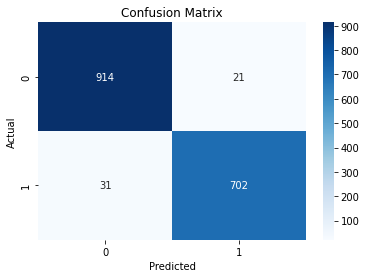

2025-01-31 03:48:12,057 - Macro-Averaged F1 Score: 0.9683


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       935
           1       0.97      0.96      0.96       733

    accuracy                           0.97      1668
   macro avg       0.97      0.97      0.97      1668
weighted avg       0.97      0.97      0.97      1668



In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset Paths (Updated)
dataset_dir = '/projects/ouzuner/mbiswas2/pubmed/FC/Dataset/modified_dataset'
img_size = (224, 224)  # EfficientNet standard input size

# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 25
NUM_CLASSES = 2  # Binary classification (Real vs Fake)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load images manually
def load_images(dataset_dir):
    images_list, labels_list, note_paths_list = [], [], []
    counter = 1

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)
        
        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')
                image = datasets.folder.default_loader(image_path)  # Uses PIL for image loading
                image = transform(image)  # Apply transformation
                images_list.append(image)
                labels_list.append(0 if class_dir == 'real_notes' else 1)
                note_paths_list.append(note_path)

                if counter % 500 == 0:
                    print(f"Processed {counter} images")
                counter += 1

    X = torch.stack(images_list)
    y = torch.tensor(labels_list, dtype=torch.long)
    return X, y, note_paths_list

# Load dataset
X, y, note_paths = load_images(dataset_dir)

# Train-validation-test split (same as original)
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(
    X, y, note_paths, test_size=0.4, random_state=10
)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(
    X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=10
)

# DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

# Load EfficientNet-B0 Model
model = models.efficientnet_b0(weights=None)  # Set weights="IMAGENET1K_V1" for pretrained
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)  # Adjust output layer
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

# Save model
torch.save(model.state_dict(), 'efficientnet_b0_custom_dataset.pth')

# Evaluate Model
def test_model(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(all_labels, all_preds, average='macro')
    logger.info(f"Macro-Averaged F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

# Test model
test_model(model, test_loader)


### VGG16

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images


2025-01-31 04:00:12,625 - Epoch 1/25: Train Loss = 0.5577, Train Acc = 0.7192
2025-01-31 04:00:15,326 - Epoch 1/25: Val Loss = 0.4024, Val Acc = 0.8267
2025-01-31 04:00:36,943 - Epoch 2/25: Train Loss = 0.2562, Train Acc = 0.9063
2025-01-31 04:00:39,149 - Epoch 2/25: Val Loss = 0.1754, Val Acc = 0.9323
2025-01-31 04:00:59,916 - Epoch 3/25: Train Loss = 0.1286, Train Acc = 0.9656
2025-01-31 04:01:02,666 - Epoch 3/25: Val Loss = 0.0916, Val Acc = 0.9772
2025-01-31 04:01:23,464 - Epoch 4/25: Train Loss = 0.1025, Train Acc = 0.9752
2025-01-31 04:01:25,687 - Epoch 4/25: Val Loss = 0.0851, Val Acc = 0.9796
2025-01-31 04:01:46,570 - Epoch 5/25: Train Loss = 0.0740, Train Acc = 0.9828
2025-01-31 04:01:48,771 - Epoch 5/25: Val Loss = 0.1077, Val Acc = 0.9742
2025-01-31 04:02:18,422 - Epoch 6/25: Train Loss = 0.0661, Train Acc = 0.9810
2025-01-31 04:02:20,714 - Epoch 6/25: Val Loss = 0.0982, Val Acc = 0.9700
2025-01-31 04:02:42,064 - Epoch 7/25: Train Loss = 0.0751, Train Acc = 0.9800
2025-01-31

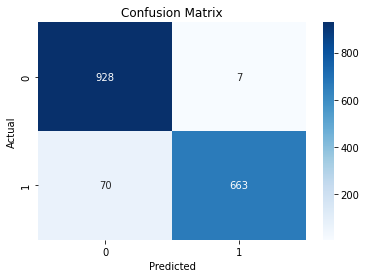

2025-01-31 04:10:25,339 - Macro-Averaged F1 Score: 0.9526


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       935
           1       0.99      0.90      0.95       733

    accuracy                           0.95      1668
   macro avg       0.96      0.95      0.95      1668
weighted avg       0.96      0.95      0.95      1668



In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset Paths
dataset_dir = '/projects/ouzuner/mbiswas2/pubmed/FC/Dataset/modified_dataset'
img_size = (224, 224)  # VGG-16 standard input size

# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 25
NUM_CLASSES = 2  # Binary classification (Real vs Fake)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load images manually
def load_images(dataset_dir):
    images_list, labels_list, note_paths_list = [], [], []
    counter = 1

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)
        
        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')
                image = datasets.folder.default_loader(image_path)  # Uses PIL for image loading
                image = transform(image)  # Apply transformation
                images_list.append(image)
                labels_list.append(0 if class_dir == 'real_notes' else 1)
                note_paths_list.append(note_path)

                if counter % 500 == 0:
                    print(f"Processed {counter} images")
                counter += 1

    X = torch.stack(images_list)
    y = torch.tensor(labels_list, dtype=torch.long)
    return X, y, note_paths_list

# Load dataset
X, y, note_paths = load_images(dataset_dir)

# Train-validation-test split (same as original)
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(
    X, y, note_paths, test_size=0.4, random_state=10
)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(
    X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=10
)

# DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

# Load VGG-16 Model (Replace EfficientNet with VGG-16)
model = models.vgg16(weights=None)  # Initialize VGG-16 without pretrained weights

# Modify the classifier for binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

# Save model
torch.save(model.state_dict(), 'vgg16_custom_dataset.pth')

# Evaluate Model
def test_model(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(all_labels, all_preds, average='macro')
    logger.info(f"Macro-Averaged F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

# Test model
test_model(model, test_loader)


### ResNet50 

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images


2025-01-31 04:21:26,336 - Epoch 1/25: Train Loss = 0.5088, Train Acc = 0.7492
2025-01-31 04:21:27,717 - Epoch 1/25: Val Loss = 0.3297, Val Acc = 0.8573
2025-01-31 04:21:41,460 - Epoch 2/25: Train Loss = 0.2858, Train Acc = 0.8811
2025-01-31 04:21:42,837 - Epoch 2/25: Val Loss = 0.4744, Val Acc = 0.8141
2025-01-31 04:21:56,687 - Epoch 3/25: Train Loss = 0.2196, Train Acc = 0.9127
2025-01-31 04:21:58,082 - Epoch 3/25: Val Loss = 0.2861, Val Acc = 0.8795
2025-01-31 04:22:09,657 - Epoch 4/25: Train Loss = 0.1630, Train Acc = 0.9432
2025-01-31 04:22:11,026 - Epoch 4/25: Val Loss = 0.5404, Val Acc = 0.8573
2025-01-31 04:22:22,587 - Epoch 5/25: Train Loss = 0.1169, Train Acc = 0.9586
2025-01-31 04:22:23,954 - Epoch 5/25: Val Loss = 0.1424, Val Acc = 0.9430
2025-01-31 04:22:36,190 - Epoch 6/25: Train Loss = 0.1259, Train Acc = 0.9558
2025-01-31 04:22:37,573 - Epoch 6/25: Val Loss = 0.2731, Val Acc = 0.9017
2025-01-31 04:22:51,487 - Epoch 7/25: Train Loss = 0.1190, Train Acc = 0.9618
2025-01-31

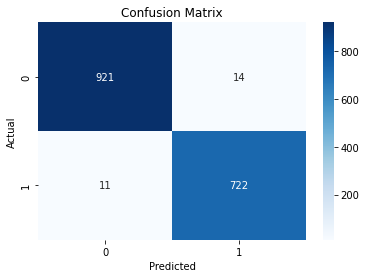

2025-01-31 04:27:04,980 - Macro-Averaged F1 Score: 0.9848


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       935
           1       0.98      0.98      0.98       733

    accuracy                           0.99      1668
   macro avg       0.98      0.99      0.98      1668
weighted avg       0.99      0.99      0.99      1668



In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset Paths
dataset_dir = '/projects/ouzuner/mbiswas2/pubmed/FC/Dataset/modified_dataset'
img_size = (224, 224)  # ResNet standard input size

# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 25
NUM_CLASSES = 2  # Binary classification (Real vs Fake)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load images manually
def load_images(dataset_dir):
    images_list, labels_list, note_paths_list = [], [], []
    counter = 1

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)
        
        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')
                image = datasets.folder.default_loader(image_path)  # Uses PIL for image loading
                image = transform(image)  # Apply transformation
                images_list.append(image)
                labels_list.append(0 if class_dir == 'real_notes' else 1)
                note_paths_list.append(note_path)

                if counter % 500 == 0:
                    print(f"Processed {counter} images")
                counter += 1

    X = torch.stack(images_list)
    y = torch.tensor(labels_list, dtype=torch.long)
    return X, y, note_paths_list

# Load dataset
X, y, note_paths = load_images(dataset_dir)

# Train-validation-test split (same as original)
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(
    X, y, note_paths, test_size=0.4, random_state=10
)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(
    X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=10
)

# DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

# Load ResNet-50 Model
model = models.resnet50(weights=None)  # Initialize ResNet-50 without pretrained weights

# Modify the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

# Save model
torch.save(model.state_dict(), 'resnet50_custom_dataset.pth')

# Evaluate Model
def test_model(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(all_labels, all_preds, average='macro')
    logger.info(f"Macro-Averaged F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

# Test model
test_model(model, test_loader)


### Inception_V3

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images


2025-01-31 04:38:47,834 - Epoch 1/25: Train Loss = 0.4489, Train Acc = 0.7938
2025-01-31 04:38:49,863 - Epoch 1/25: Val Loss = 0.3214, Val Acc = 0.8657
2025-01-31 04:39:10,901 - Epoch 2/25: Train Loss = 0.2015, Train Acc = 0.9253
2025-01-31 04:39:12,831 - Epoch 2/25: Val Loss = 0.1616, Val Acc = 0.9466
2025-01-31 04:39:32,742 - Epoch 3/25: Train Loss = 0.1180, Train Acc = 0.9608
2025-01-31 04:39:34,948 - Epoch 3/25: Val Loss = 0.0932, Val Acc = 0.9694
2025-01-31 04:39:56,781 - Epoch 4/25: Train Loss = 0.0897, Train Acc = 0.9710
2025-01-31 04:39:58,622 - Epoch 4/25: Val Loss = 0.1498, Val Acc = 0.9454
2025-01-31 04:40:17,305 - Epoch 5/25: Train Loss = 0.0743, Train Acc = 0.9770
2025-01-31 04:40:20,433 - Epoch 5/25: Val Loss = 0.1120, Val Acc = 0.9724
2025-01-31 04:40:39,696 - Epoch 6/25: Train Loss = 0.0528, Train Acc = 0.9824
2025-01-31 04:40:41,518 - Epoch 6/25: Val Loss = 0.0650, Val Acc = 0.9850
2025-01-31 04:41:00,103 - Epoch 7/25: Train Loss = 0.0510, Train Acc = 0.9824
2025-01-31

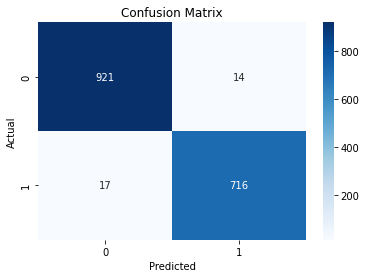

2025-01-31 04:47:50,331 - Macro-Averaged F1 Score: 0.9811


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       935
           1       0.98      0.98      0.98       733

    accuracy                           0.98      1668
   macro avg       0.98      0.98      0.98      1668
weighted avg       0.98      0.98      0.98      1668



In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset Paths
dataset_dir = '/projects/ouzuner/mbiswas2/pubmed/FC/Dataset/modified_dataset'
img_size = (299, 299)  # InceptionV3 requires 299x299 input

# Hyperparameters
batch_size = 64
learning_rate = 0.0001
epochs = 25
NUM_CLASSES = 2  # Binary classification (Real vs Fake)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load images manually
def load_images(dataset_dir):
    images_list, labels_list, note_paths_list = [], [], []
    counter = 1

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)
        
        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')
                image = datasets.folder.default_loader(image_path)  # Uses PIL for image loading
                image = transform(image)  # Apply transformation
                images_list.append(image)
                labels_list.append(0 if class_dir == 'real_notes' else 1)
                note_paths_list.append(note_path)

                if counter % 500 == 0:
                    print(f"Processed {counter} images")
                counter += 1

    X = torch.stack(images_list)
    y = torch.tensor(labels_list, dtype=torch.long)
    return X, y, note_paths_list

# Load dataset
X, y, note_paths = load_images(dataset_dir)

# Train-validation-test split (same as original)
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(
    X, y, note_paths, test_size=0.4, random_state=10
)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(
    X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=10
)

# DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

# Load InceptionV3 Model
model = models.inception_v3(weights=None, aux_logits=False, init_weights=True)  # Initialize InceptionV3 without pretrained weights

# Modify the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        logger.info(f"Epoch {epoch + 1}/{epochs}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Train the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

# Save model
torch.save(model.state_dict(), 'inception_v3_custom_dataset.pth')

# Evaluate Model
def test_model(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(all_labels, all_preds, average='macro')
    logger.info(f"Macro-Averaged F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

# Test model
test_model(model, test_loader)
